# Split MaSTr1325 Dataset
|Dataset|\%|Number|
|:-:|:-:|:-:|
|Training|70|927|
|Validation|20|266|
|Test|10|132|

In [23]:
# Initialization
import os
import shutil
import random
from sklearn.model_selection import train_test_split

root = 'MaSTr1325'
img_dir = 'MaSTr1325_images_512x384'
mask_dir = 'MaSTr1325_masks_512x384'

# Target Path
train_img_dir = os.path.join(root, 'train')
train_mask_dir = os.path.join(root, 'train_mask')
val_img_dir = os.path.join(root, 'val')
val_mask_dir = os.path.join(root, 'val_mask')
test_img_dir = os.path.join(root, 'test')
test_mask_dir = os.path.join(root, 'test_mask')

# `mkdir dirs`
for d in [train_img_dir, train_mask_dir, val_img_dir, val_mask_dir, test_img_dir, test_mask_dir]:
    os.makedirs(d, exist_ok=True)

images = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
masks = [f for f in os.listdir(mask_dir) if f.endswith('.png')]

# make sure the images and masks aligned
images.sort()
masks.sort()
assert len(images) == len(masks), "Number of images and masks do not match"

# Split Original Dataset
train_imgs, temp_imgs, train_masks, temp_masks = train_test_split(images, masks, test_size=0.3, random_state=42)
val_imgs, test_imgs, val_masks, test_masks = train_test_split(temp_imgs, temp_masks, test_size=0.33, random_state=42)

# Move File Function
def move_files(file_list, src_dir, dest_dir):
    for file in file_list:
        shutil.move(os.path.join(src_dir, file), os.path.join(dest_dir, file))

# Move Training Dataset
move_files(train_imgs, img_dir, train_img_dir)
move_files(train_masks, mask_dir, train_mask_dir)

# Move Validation Dataset
move_files(val_imgs, img_dir, val_img_dir)
move_files(val_masks, mask_dir, val_mask_dir)

# Move Testing Dataset
move_files(test_imgs, img_dir, test_img_dir)
move_files(test_masks, mask_dir, test_mask_dir)


In [24]:
print("Training set size:", len(os.listdir(train_img_dir)))
print("Validation set size:", len(os.listdir(val_img_dir)))
print("Test set size:", len(os.listdir(test_img_dir)))

Training set size: 927
Validation set size: 266
Test set size: 132


# Generate test dataset with Gaussian Noise (MaSTr1325)

In [7]:
import cv2
import os
import numpy as np
from tqdm import tqdm

# Standard Deviation
std = 0.05

# Define file paths
input_folder = './MaSTr1325/test/'
output_folder = f'./MaSTr1325/test-g{std}/'

# Create output file
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Add Gaussian Blur
image_files = [f for f in os.listdir(input_folder) if f.endswith('.jpg')]
for filename in tqdm(image_files, desc=f'Add Gaussian Blur σ = {std}'):
    input_path = os.path.join(input_folder, filename)
    output_path = os.path.join(output_folder, filename)
    # Read and Process Images
    image = cv2.imread(input_path)
    image = image.astype(np.float32) / 255.0
    mean = 0
    gaussian_noise = np.random.normal(mean, std, image.shape)
    noisy_image = image + gaussian_noise
    noisy_image = np.clip(noisy_image, 0, 1)
    noisy_image = (noisy_image * 255).astype(np.uint8)
    cv2.imwrite(output_path, noisy_image)

Add Gaussian Blur σ = 0.05: 100%|██████████| 132/132 [00:01<00:00, 83.81it/s]


# OASIs Dataset Mask Conversion
|Class|Grayscale|Annotated Numbers|Annotation Conversion|
|:-:|:-:|:-:|:--|
|Others|0|2|`Others` ==> `sky`|
|Sky|50|1|`Sky` ==> `water`|
|Land|100|0|`Land` ==> `obstacle & environment`|
|Sea Objects|150|0|`Sea Objects` ==> `obstacle & environment`|

In [ ]:
import cv2
import os
import numpy as np
from tqdm import trange

def mask_replace(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mask = np.zeros_like(image, dtype=np.uint8)
    mask[image == 0] = 2
    mask[image == 50] = 1
    mask[(image == 100) | (image == 150)] = 0
    cv2.imwrite(image_path, mask)

for i in range(1,4):
    root = f"./OASIs/type{i}_mask"
    for j in trange(1, len(os.listdir(root))+1):
        img_path = os.path.join(root, f"{j:03d}m.png")
        mask_replace(img_path)

# MaSTr1325 Ground Truth Display

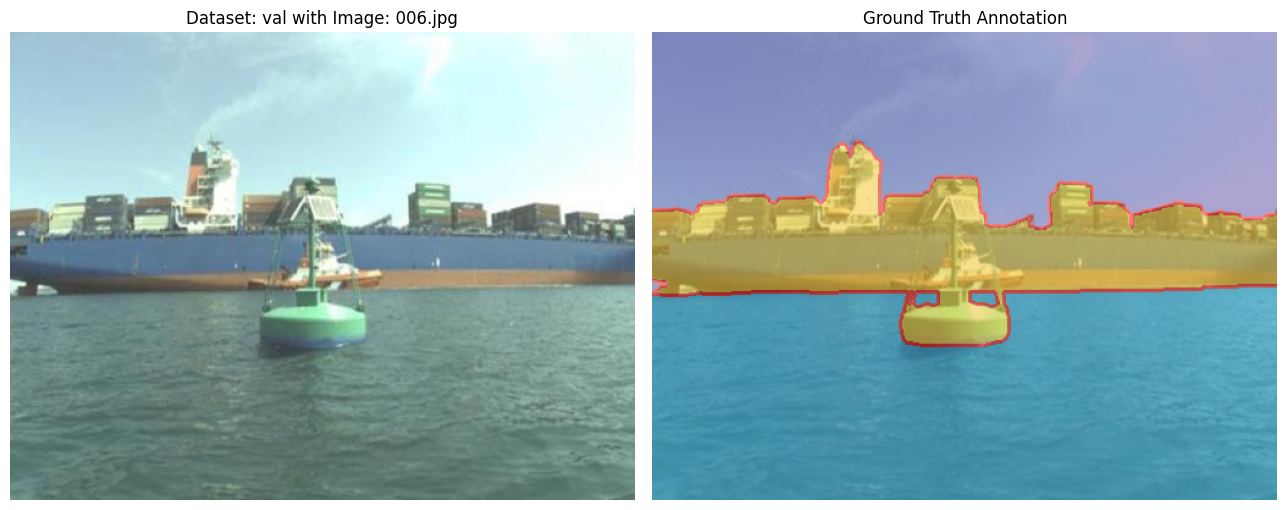

In [13]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Choose dataset and images
dataset = "val" # val / test
img_number = 6  # val: 1-266 / test: 1-132
# Path
root = os.path.expanduser("./MaSTr1325")
jpg_path = os.path.join(root, f'{dataset}/{img_number:03d}.jpg')
png_path = os.path.join(root, f'{dataset}_mask/{img_number:03d}m.png')

# Define Colour
colors = {
    0: (247, 195, 37, 128),    # yellow (RGBA) = obstacle & environment
    1: (41, 167, 224, 128),    # cyan-blue (RGBA) = water
    2: (90, 75, 164, 128),     # purple (RGBA) = sky
    4: (255, 0, 0, 128)        # red (RGBA) = unknown
}

image = Image.open(jpg_path).convert('RGBA')
mask_data = Image.open(png_path)
mask_array = np.array(mask_data)
mask_image = Image.new('RGBA', image.size)
mask_pixels = mask_image.load()
for y in range(mask_array.shape[0]):
    for x in range(mask_array.shape[1]):
        value = mask_array[y, x]
        if value in colors:
            mask_pixels[x, y] = colors[value]
# apply mask to jpg
combined = Image.alpha_composite(image, mask_image)
    
# Plot
plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title(f'Dataset: {dataset} with Image: {img_number:03d}.jpg')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(combined)
plt.title(f'Ground Truth Annotation')
plt.axis('off')
plt.tight_layout()
plt.show()

# OASIs Ground Truth Display

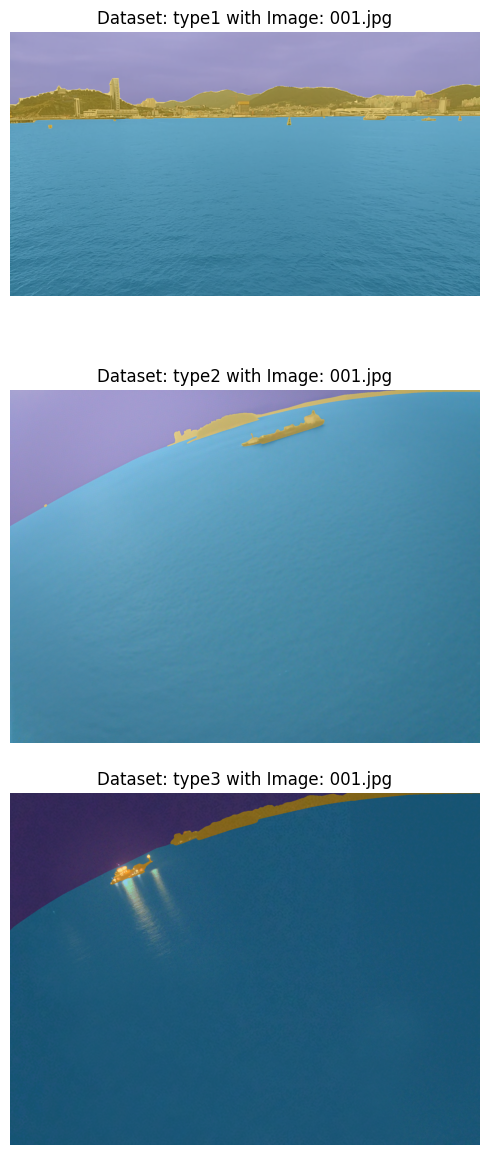

In [20]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# root path
root = os.path.expanduser("./OASIs")


def GTDisplay(jpg_path, png_path):
    # define colour
    colors = {
        0: (247, 195, 37, 128),    # yellow (RGBA) = obstacle & environment
        1: (41, 167, 224, 128),    # cyan-blue (RGBA) = water
        2: (90, 75, 164, 128),     # purple (RGBA) = sky
        4: (255, 0, 0, 128)        # red (RGBA) = unknown
    }
    image = Image.open(jpg_path).convert('RGBA')
    mask_data = Image.open(png_path)
    mask_array = np.array(mask_data)
    mask_image = Image.new('RGBA', image.size)
    mask_pixels = mask_image.load()
    for y in range(mask_array.shape[0]):
        for x in range(mask_array.shape[1]):
            value = mask_array[y, x]
            if value in colors:
                mask_pixels[x, y] = colors[value]
    # apply mask to jpg
    combined = Image.alpha_composite(image, mask_image)
    
    return combined


img_number = 1
combined = {}

for scenario in range (1,4): # 1: Day-Time / 2: Adverse Weather / 3: Night-Time
    jpg_path = os.path.join(root, f'type{scenario}/{img_number:03d}.jpg')
    png_path = os.path.join(root, f'type{scenario}_mask/{img_number:03d}m.png')
    combined[scenario] = GTDisplay(jpg_path, png_path)
    
# Plot
plt.figure(figsize=(5, 12))
plt.subplot(3, 1, 1)
plt.imshow(combined[1])
plt.title(f'Dataset: type1 with Image: {img_number:03d}.jpg')
plt.axis('off')
plt.subplot(3, 1, 2)
plt.imshow(combined[2])
plt.title(f'Dataset: type2 with Image: {img_number:03d}.jpg')
plt.axis('off')
plt.subplot(3, 1, 3)
plt.imshow(combined[3])
plt.title(f'Dataset: type3 with Image: {img_number:03d}.jpg')
plt.axis('off')
plt.tight_layout()
plt.show()
